In [1]:
import sys
import numpy as np
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
import time

# for debugging
import scipy.interpolate

Detected 16 CPU's. Setting n_jobs to #CPU/2.


# Testing display_content() (Works!)

A


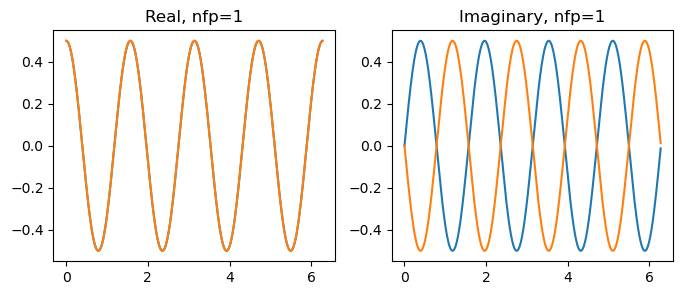

B


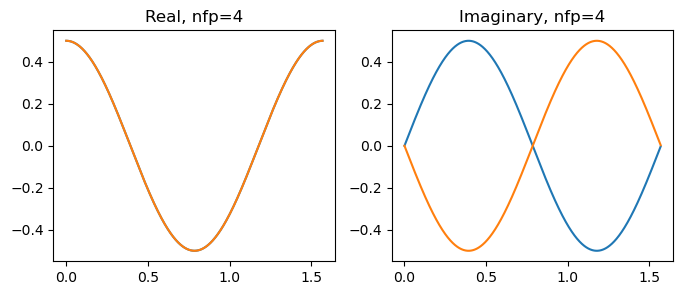

One of A and B is converted to have nfp=1.
A.nfp = 1
B.nfp = 4
A


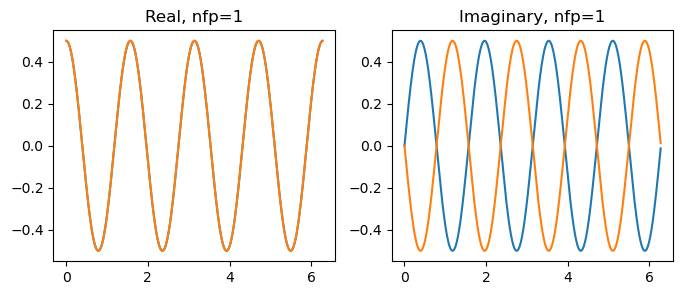

B


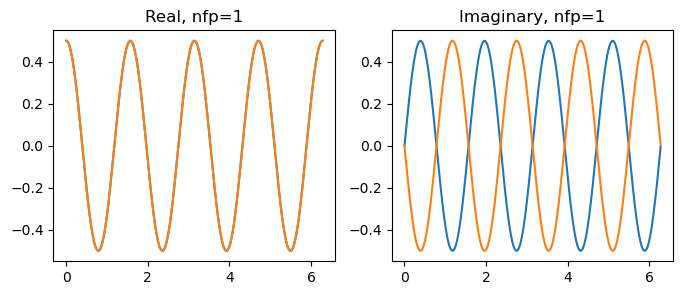

Difference


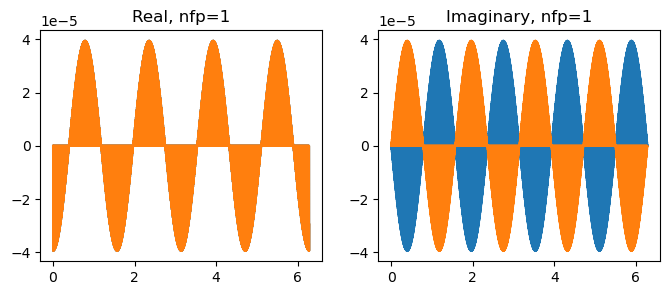

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.699e-02       1.571e-05      
Worst:          4.604e+01       3.947e-05      
Std             7.434e-01       1.293e-05      
Total imaginary component
0.0



/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content


()

In [2]:
content1 = np.array([
    np.sin(points), # sin component
    np.cos(points) # cos component
])

content_single_nfp = np.array([
    np.sin(4*points), # sin component
    np.cos(4*points) # cos component
])

single_period = ChiPhiFunc(content_single_nfp, nfp=1, fourier_mode = True)
four_period = ChiPhiFunc(content1, nfp=4, fourier_mode = True)
compare_chiphifunc(single_period, four_period, simple_mode=False)

# Defining test variables

In [ ]:
# Generating 2 random test cases and answers
nfp = np.random.randint(4)+2

# Creating 2 random ChiPhiFunc's for testing
rands1 = np.random.randint(5, size=12)
func1 = np.vectorize(lambda chi, phi : \
    (rands1[0]/10*np.sin(rands1[1]*nfp*phi) + rands1[2]/10*np.cos(rands1[3]*nfp*phi))*np.sin(2*chi)+\
    rands1[4]/10*np.sin(rands1[5]*nfp*phi) + rands1[6]/10*np.cos(rands1[7]*nfp*phi)+\
    (rands1[8]/10*np.sin(rands1[9]*nfp*phi) + rands1[10]/10*np.cos(rands1[11]*nfp*phi))*np.cos(2*chi))

content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)
])


rands2 = np.random.randint(5, size=12)
func2 = np.vectorize(lambda chi, phi : \
    (rands2[0]/10*np.sin(rands2[1]*nfp*phi) + rands2[2]/10*np.cos(rands2[3]*nfp*phi))*np.sin(2*chi)+\
    rands2[4]/10*np.sin(rands2[5]*nfp*phi) + rands2[6]/10*np.cos(rands2[7]*nfp*phi)+\
    (rands2[8]/10*np.sin(rands2[9]*nfp*phi) + rands2[10]/10*np.cos(rands2[11]*nfp*phi))*np.cos(2*chi))
content2 = np.array([
    rands2[0]/10*np.sin(rands2[1]*points) + rands2[2]/10*np.cos(rands2[3]*points),
    rands2[4]/10*np.sin(rands2[5]*points) + rands2[6]/10*np.cos(rands2[7]*points),
    rands2[8]/10*np.sin(rands2[9]*points) + rands2[10]/10*np.cos(rands2[11]*points)
])

randsodd = np.random.randint(5, size=16)
funcodd = np.vectorize(lambda chi, phi : \
    (randsodd[0]/10*np.sin(randsodd[1]*nfp*phi) + randsodd[2]/10*np.cos(randsodd[3]*nfp*phi))*np.sin(3*chi)+\
    (randsodd[4]/10*np.sin(randsodd[5]*nfp*phi) + randsodd[6]/10*np.cos(randsodd[7]*nfp*phi))*np.sin(1*chi)+\
    (randsodd[8]/10*np.sin(randsodd[9]*nfp*phi) + randsodd[10]/10*np.cos(randsodd[11]*nfp*phi))*np.cos(1*chi)+\
    (randsodd[12]/10*np.sin(randsodd[13]*nfp*phi) + randsodd[14]/10*np.cos(randsodd[15]*nfp*phi))*np.cos(3*chi))
contentodd = np.array([
    randsodd[0]/10*np.sin(randsodd[1]*points) + randsodd[2]/10*np.cos(randsodd[3]*points),
    randsodd[4]/10*np.sin(randsodd[5]*points) + randsodd[6]/10*np.cos(randsodd[7]*points),
    randsodd[8]/10*np.sin(randsodd[9]*points) + randsodd[10]/10*np.cos(randsodd[11]*points),
    randsodd[12]/10*np.sin(randsodd[13]*points) + randsodd[14]/10*np.cos(randsodd[15]*points)
])


rands3 = np.random.randint(low=1, high=5, size=2)
func_no_chi = np.vectorize(lambda chi, phi : 
    np.sin(rands3[0]*nfp*phi) + np.cos(rands3[1]*nfp*phi)+2)
content_no_chi = np.array([
    np.sin(rands3[0]*points) + np.cos(rands3[1]*points) + 2
])
test1 = ChiPhiFunc(content1, nfp, fourier_mode = True)
test2 = ChiPhiFunc(content2, nfp, fourier_mode = True)
testodd = ChiPhiFunc(contentodd, nfp, fourier_mode = True)
test_no_chi = ChiPhiFunc(content_no_chi, nfp, fourier_mode = True)

# plt.pcolormesh(chi, phi, func1_result)
# plt.show()
test1.display_content()
test2.display_content()
test_no_chi.display_content()




In [17]:
funcodd_result = evaluate(funcodd)
func1_result = evaluate(func1)
func2_result = evaluate(func2)
func_no_chi_result = evaluate(func_no_chi)

# Testing basic operations (Works!)

In [18]:
print('Testing lambda:') # Works!
print_fractional_error(evaluate_ChiPhiFunc(testodd), (funcodd_result))

Testing lambda:
Error type:     Fractional      Total          
Avg:            4.000e-06       1.938e-16      
Worst:          1.5e+00         2.165e-15      
Std             2.236e-03       2.668e-16      
Total imaginary component
0.0



In [19]:
print('Testing +:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd+testodd), (funcodd_result+funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1+test2+1), (func1_result+func2_result+1))

print('Testing -:')
print_fractional_error(evaluate_ChiPhiFunc(test1-test2-test_no_chi), (func1_result-func2_result-func_no_chi_result))

print('Testing *:')
print('Odd-odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd*testodd), (funcodd_result*funcodd_result))
print('Even-even:')
print_fractional_error(evaluate_ChiPhiFunc(test1*test2), (func1_result*func2_result))
print('Even-odd:')
print_fractional_error(evaluate_ChiPhiFunc(test1*testodd), (func1_result*funcodd_result))

print('Testing /:')
print('Even:')
print_fractional_error(evaluate_ChiPhiFunc(test1/(test_no_chi+10)), (func1_result/(func_no_chi_result+10)))
print('Odd:')
print_fractional_error(evaluate_ChiPhiFunc(testodd/(test_no_chi+10)), (funcodd_result/(func_no_chi_result+10)))


print('Testing **:')
print_fractional_error(evaluate_ChiPhiFunc(test1**3), (func1_result*func1_result*func1_result))
print_fractional_error(evaluate_ChiPhiFunc(testodd**3), (funcodd_result*funcodd_result*funcodd_result))


Testing +:
Odd-odd:
Error type:     Fractional      Total          
Avg:            4.000e-06       3.877e-16      
Worst:          1.5e+00         4.33e-15       
Std             2.236e-03       5.336e-16      
Total imaginary component
0.0

Even-even:
Error type:     Fractional      Total          
Avg:            4.942e-16       2.048e-16      
Worst:          3.852e-12       1.776e-15      
Std             1.065e-14       2.353e-16      
Total imaginary component
0.0

Testing -:
Error type:     Fractional      Total          
Avg:            7.250e-16       3.557e-16      
Worst:          3.696e-11       2.665e-15      
Std             7.601e-14       3.946e-16      
Total imaginary component
0.0

Testing *:
Odd-odd:
Error type:     Fractional      Total          
Avg:            1.239e+10       1.556e-16      
Worst:          4.785e+15       3.664e-15      
Std             6.96e+12        2.203e-16      
Total imaginary component
0.0

Even-even:


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:160: RuntimeWarning: divide by zero encountered in divide
  frac = np.abs((guess-ans)/ans)
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:160: RuntimeWarning: invalid value encountered in divide
  frac = np.abs((guess-ans)/ans)


Error type:     Fractional      Total          
Avg:            nan             5.854e-17      
Worst:          inf             8.327e-16      
Std             nan             8.397e-17      
Total imaginary component
0.0

Even-odd:
Error type:     Fractional      Total          
Avg:            1.605e-05       9.242e-17      
Worst:          2.875e+00       1.342e-15      
Std             5.274e-03       1.156e-16      
Total imaginary component
0.0

Testing /:
Even:
Error type:     Fractional      Total          
Avg:            5.711e-06       9.769e-18      
Worst:          1.550e+00       9.021e-17      
Std             2.556e-03       1.384e-17      
Total imaginary component
0.0

Odd:
Error type:     Fractional      Total          
Avg:            6.750e-06       1.735e-17      
Worst:          1.688e+00       2.082e-16      
Std             2.905e-03       2.280e-17      
Total imaginary component
0.0

Testing **:
Error type:     Fractional      Total          
Avg:            

## Basic operations, cumulative Error

# Testing differential and integral (Works!)

## $\partial_\chi$ and $\int d\chi$ (Works!)

Testing dchi and ichi (even)
dchi
Difference


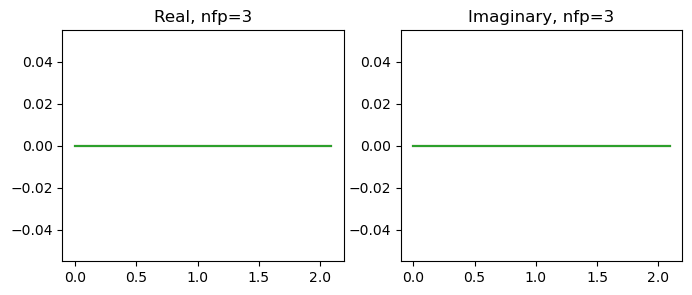

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0

ichi
Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:161: ComplexWarning: Casting complex values to real discards the imaginary part
  A_content_padded[a_pad_row:shape[0]-a_pad_row,a_pad_col:shape[1]-a_pad_col] = A.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:162: ComplexWarning: Casting complex values to real discards the imaginary part
  B_content_padded[b_pad_row:shape[0]-b_pad_row,b_pad_col:shape[1]-b_pad_col] = B.content
/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:170: RuntimeWarning: invalid value encountered in divide
  frac = np.abs((guess-ans)/ans)


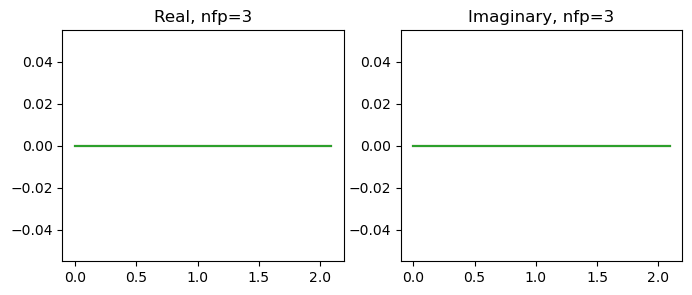

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0



In [3]:
nfp = np.random.randint(4)+2
print('Testing dchi and ichi (even)')
rands_i = np.random.randint(1,5, size=12)
amp=0.2
test1 = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), nfp, fourier_mode = True)

test1_int = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.zeros_like(points, dtype=np.complex128),
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), nfp, fourier_mode = True)

dchi_test1 = amp*ChiPhiFunc(np.array([
        -2*(np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)), 
        np.zeros_like(points, dtype=np.complex128),
        2*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), nfp, fourier_mode = True)

guess_dchi = diff(test1,'chi',1)
guess_ichi = int_chi(dchi_test1)
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1_int)

Testing dchi and ichi (odd)
dchi
Difference


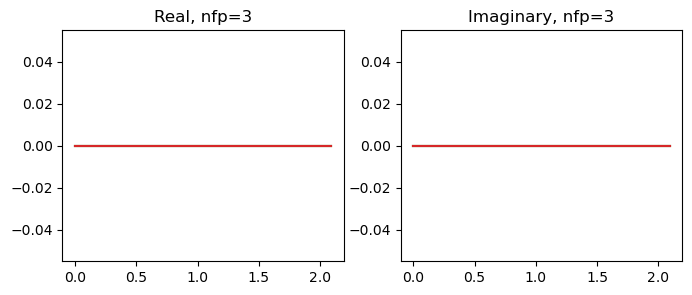

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             0.e+00         
Worst:          0.e+00          0.e+00         
Std             nan             0.e+00         
Total imaginary component
0.0

ichi
Difference


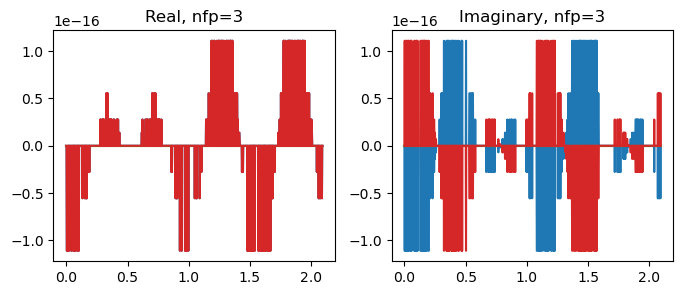

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             8.58e-18       
Worst:          2.201e-16       1.110e-16      
Std             nan             2.685e-17      
Total imaginary component
0.0



In [4]:
print('Testing dchi and ichi (odd)')
nfp = np.random.randint(4)+2
rands_i = np.random.randint(1,5, size=12)

test1 = ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points), 
        np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)
]), nfp, fourier_mode = True)

dchi_test1 = ChiPhiFunc(np.array([
        -3*(np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points)), 
        -(np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        3*(np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points))
]), nfp, fourier_mode = True)

guess_dchi = diff(test1,'chi',1)
guess_ichi = dchi_test1.integrate_chi()
print('dchi')
compare_chiphifunc(guess_dchi, dchi_test1)
print('ichi')
compare_chiphifunc(guess_ichi, test1, fourier_mode = False)

## $\partial_\phi$ and $\int d\phi$ (Works!)

Testing dphi
Current derivative modes: fft
Current integral modes: fft
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
dphi based on FFT
Difference


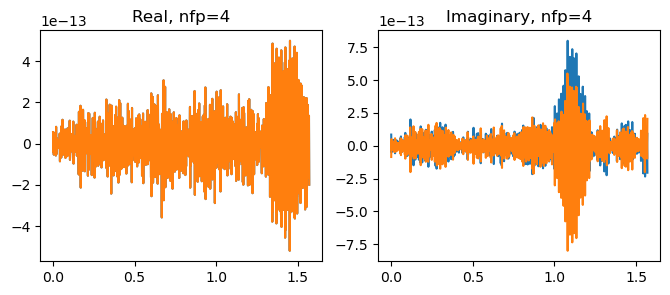

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             9.709e-14      
Worst:          inf             5.195e-13      
Std             nan             8.804e-14      
Total imaginary component
0.0

dphi based on pseudo-spectral
Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:170: RuntimeWarning: divide by zero encountered in divide
  frac = np.abs((guess-ans)/ans)
/Users/lanke/anaconda3/envs/nae/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


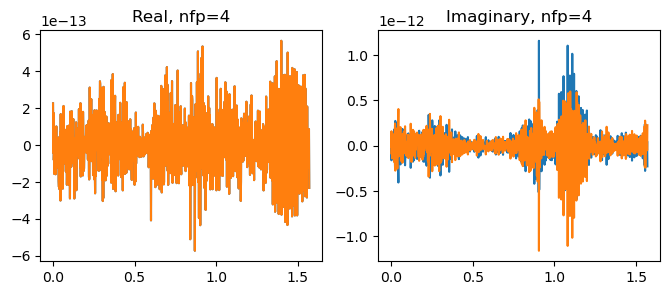

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             1.225e-13      
Worst:          inf             5.723e-13      
Std             nan             1.018e-13      
Total imaginary component
0.0

spline
Difference


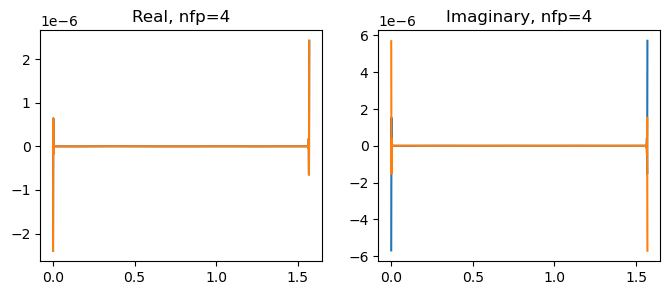

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             7.478e-09      
Worst:          inf             2.421e-06      
Std             nan             1.116e-07      
Total imaginary component
0.0



In [3]:
print('Testing dphi')
nfp = np.random.randint(4)+2
chiphifunc.diff_mode = 'fft'
print('Current derivative modes:', chiphifunc.diff_mode)
print('Current integral modes:', chiphifunc.integral_mode)
rands_i = np.random.randint(1,5, size=12)
test_diff = ChiPhiFunc(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), nfp, fourier_mode = True)

ans = ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
]), nfp, fourier_mode = True)*nfp

guess_fft = diff(test_diff,'phi',1)
guess_pseudo_spectral = test_diff.dphi(mode = 'pseudo_spectral')
guess_spline = test_diff.dphi(mode = 'spline')
print('dphi based on FFT')
compare_chiphifunc(guess_fft, ans)
print('dphi based on pseudo-spectral')
dphi_op = dphi_op_pseudospectral(n_grid_phi)
compare_chiphifunc(guess_pseudo_spectral, ans)
print('spline')
compare_chiphifunc(guess_spline, ans)

Testing integrate_phi
Testing periodic: simpson
Error type:     Fractional      Total          
Avg:            1.74e+00        1.438e-17      
Worst:          2.489e+00       2.487e-17      
Std             5.299e-01       7.424e-18      
Total imaginary component
0.0

Testing periodic: spline
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
Error type:     Fractional      Total          
Avg:            4.035e+06       2.822e-11      
Worst:          5.484e+06       3.666e-11      
Std             2.05e+06        1.193e-11      
Total imaginary component
0.0

Testing general
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
Simpson v. ans
Difference


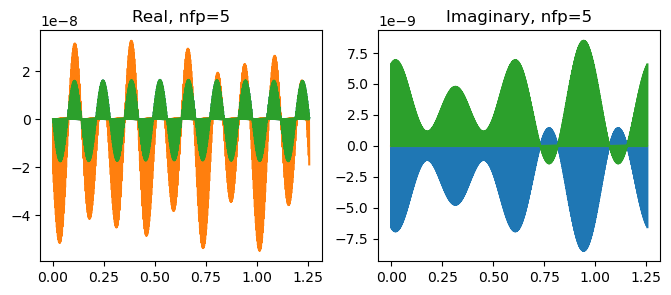

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             7.478e-09      
Worst:          1.068e-03       5.469e-08      
Std             nan             1.066e-08      
Total imaginary component
0.0

Spline v. ans
Difference


/Users/lanke/Desktop/Second year project/Code/python_source/chiphifunc_test_suite.py:170: RuntimeWarning: invalid value encountered in divide
  frac = np.abs((guess-ans)/ans)


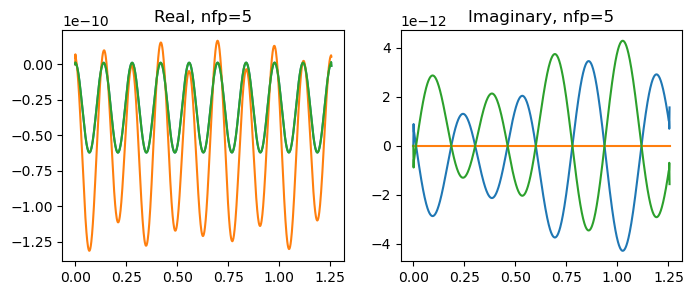

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             4.016e-11      
Worst:          1.245e-05       1.312e-10      
Std             nan             3.350e-11      
Total imaginary component
0.0

FFT v. ans
Difference


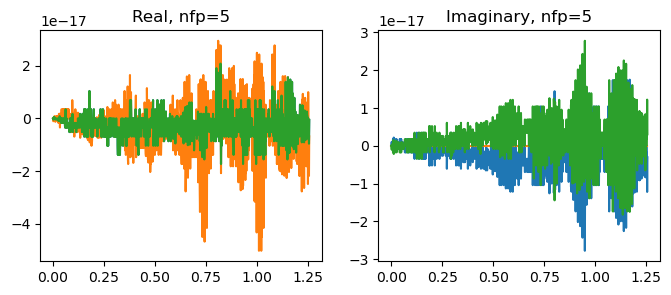

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             5.313e-18      
Worst:          2.244e-12       5.031e-17      
Std             nan             5.448e-18      
Total imaginary component
0.0



In [4]:
print('Testing integrate_phi')
amp=0.2
nfp = np.random.randint(4)+2

rands_i = np.random.randint(1,10, size=12)
test_integral = amp*ChiPhiFunc(np.array([
        np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points), 
        np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points), 
        np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points)
]),nfp, fourier_mode = True)

ans = amp*ChiPhiFunc(np.array([
        -1/rands_i[0]*np.cos(rands_i[0]*points) + 1/rands_i[1]*np.sin(rands_i[1]*points) +1/rands_i[0],
        -1/rands_i[2]*np.cos(rands_i[2]*points) + 1/rands_i[3]*np.sin(rands_i[3]*points) +1/rands_i[2],
        -1/rands_i[4]*np.cos(rands_i[4]*points) + 1/rands_i[5]*np.sin(rands_i[5]*points) +1/rands_i[4]
]), nfp, fourier_mode = True)/nfp


ans_2pi = amp*ChiPhiFunc(np.array([
        [-1/rands_i[0]*np.cos(rands_i[0]*2*np.pi) + 1/rands_i[1]*np.sin(rands_i[1]*2*np.pi) +1/rands_i[0]*np.cos(0)],
        [-1/rands_i[2]*np.cos(rands_i[2]*2*np.pi) + 1/rands_i[3]*np.sin(rands_i[3]*2*np.pi) +1/rands_i[2]*np.cos(0)],
        [-1/rands_i[4]*np.cos(rands_i[4]*2*np.pi) + 1/rands_i[5]*np.sin(rands_i[5]*2*np.pi) +1/rands_i[4]*np.cos(0)]
]), nfp, fourier_mode = True)/nfp
print('Testing periodic: simpson')
print_fractional_error(test_integral.integrate_phi(periodic=True, zero_avg=None, mode = 'simpson').content,ans_2pi.content)
print('Testing periodic: spline')
print_fractional_error(test_integral.integrate_phi(periodic=True, zero_avg=None, mode = 'spline').content,ans_2pi.content)

print('Testing general')
guess = test_integral.integrate_phi(periodic=False, zero_avg=False, mode='simpson')
guess_spline = test_integral.integrate_phi(periodic=False, zero_avg=False, mode='spline')
guess_fft = test_integral.integrate_phi(periodic=False, zero_avg=False, mode='fft')

print('Simpson v. ans')
compare_chiphifunc(guess, ans, fourier_mode = False)
print('Spline v. ans')
compare_chiphifunc(guess_spline, ans, fourier_mode = False)
print('FFT v. ans')
compare_chiphifunc(guess_fft, ans)


In [5]:
a = np.array([[1,2],[3,4]])
a[:,0][:,None]

array([[1],
       [3]])

## `diff()` (Works!)

Testing diff()
dphi fft
Error type:     Fractional      Total          
Avg:            1.588e-13       5.082e-12      
Worst:          5.729e-10       4.485e-11      
Std             3.440e-12       6.409e-12      
Total imaginary component
0.0

This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
dphi spline
Error type:     Fractional      Total          
Avg:            4.699e-06       3.218e-04      
Worst:          6.469e-03       6.171e-02      
Std             5.521e-05       3.072e-03      
Total imaginary component
0.0

dphi finite_difference


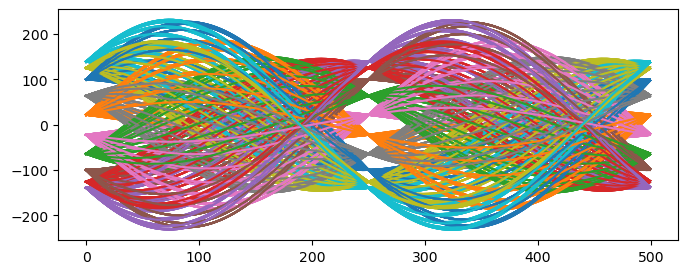

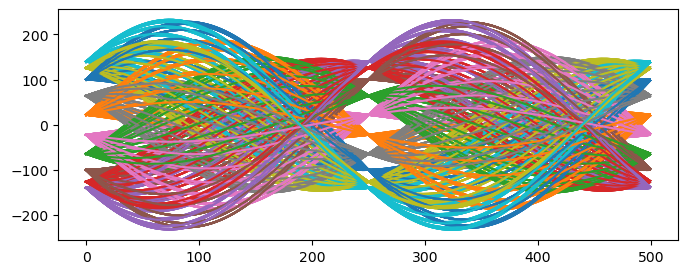

Error type:     Fractional      Total          
Avg:            3.284e-03       2.306e-01      
Worst:          1.951e+00       6.628e-01      
Std             1.638e-02       1.504e-01      
Total imaginary component
0.0

Testing dchi on chi phi array (for testing recursion relations)
dchi
Error type:     Fractional      Total          
Avg:            0.e+00          0.e+00         
Worst:          0.e+00          0.e+00         
Std             0.e+00          0.e+00         
Total imaginary component
0.0



In [9]:
print('Testing diff()')
rands_i = np.random.randint(20,22, size=12)
test_diff = ChiPhiFunc(np.array([
        np.cos(rands_i[0]*points) + np.sin(rands_i[1]*points) +1/rands_i[0]*np.cos(0),
        np.cos(rands_i[2]*points) + np.sin(rands_i[3]*points) +1/rands_i[2]*np.cos(0)
]), nfp, fourier_mode = True)

ans = ChiPhiFunc(np.array([
        -rands_i[0]*np.sin(rands_i[0]*points)+rands_i[1]*np.cos(rands_i[1]*points), 
        -rands_i[2]*np.sin(rands_i[2]*points)+rands_i[3]*np.cos(rands_i[3]*points)
]), nfp, fourier_mode = True)*nfp
guess = diff(test_diff,'phi',1)
guess_fft = test_diff.dphi(mode = 'fft', order = 1)
print('dphi fft')
print_fractional_error(evaluate_ChiPhiFunc(guess_fft), evaluate_ChiPhiFunc(ans))
guess_spline = test_diff.dphi(mode = 'spline', order = 1)
print('dphi spline')
print_fractional_error(evaluate_ChiPhiFunc(guess_spline), evaluate_ChiPhiFunc(ans))
guess_finite_difference = test_diff.dphi(mode = 'finite_difference', order = 1)
print('dphi finite_difference')
print_fractional_error(evaluate_ChiPhiFunc(guess_finite_difference), evaluate_ChiPhiFunc(ans))

print('Testing dchi on chi phi array (for testing recursion relations)')
rands_i = np.random.randint(1,5, size=12)
a = np.sin(rands_i[0]*points)+np.cos(rands_i[1]*points) 
b = np.sin(rands_i[2]*points)+np.cos(rands_i[3]*points)
c = np.sin(rands_i[4]*points)+np.cos(rands_i[5]*points) 
d = np.sin(rands_i[6]*points)+np.cos(rands_i[7]*points) 
e = np.sin(rands_i[8]*points)+np.cos(rands_i[9]*points)
test_diff = ChiPhiFunc(np.array([a,b,c,d,e]), nfp, fourier_mode = True)

ans = ChiPhiFunc(np.array([-4*e,-2*d,np.zeros_like(c),2*b,4*a]), nfp, fourier_mode = True)

guess = diff(test_diff,'chi',1)
print('dchi')
print_fractional_error(evaluate_ChiPhiFunc(guess), evaluate_ChiPhiFunc(ans))

# Testing $\phi$ ODE solvers (Works, except spline is slightly non-periodic)

In [2]:
# Creating 2 random ChiPhiFunc's for testing
rands1 = np.random.randint(5, size=16)

content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points),
    rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)
])
test1 = ChiPhiFunc(content1, 1, fourier_mode = True)
iota = np.random.rand()# rational: np.random.randint(1,5)/np.random.randint(1,5)
# dphi + iota*dchi
dphi_test1 = ChiPhiFunc(np.array([
    rands1[1]*rands1[0]/10*np.cos(rands1[1]*points) - rands1[3]*rands1[2]/10*np.sin(rands1[3]*points),
    rands1[5]*rands1[4]/10*np.cos(rands1[5]*points) - rands1[7]*rands1[6]/10*np.sin(rands1[7]*points),
    rands1[9]*rands1[8]/10*np.cos(rands1[9]*points) - rands1[11]*rands1[10]/10*np.sin(rands1[11]*points),
    rands1[13]*rands1[12]/10*np.cos(rands1[13]*points) - rands1[15]*rands1[14]/10*np.sin(rands1[15]*points)
]), 1, fourier_mode = True)

dchi_test1 = ChiPhiFunc(np.array([
    -3*(rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points)),
    -(rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points)),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    3*(rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points))
]), 1, fourier_mode = True)


Testing general integrating factor
integral_mode is asymptotic
Batch asymptotic time(s): 0.022869110107421875
Difference


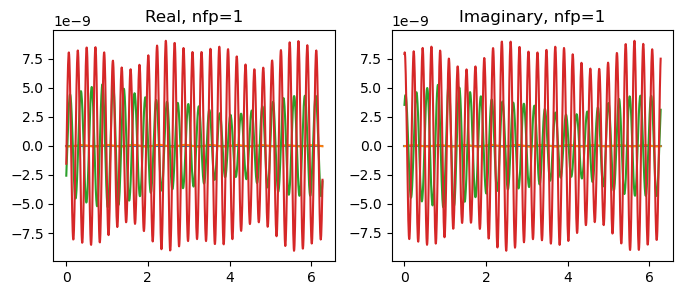

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             1.912e-09      
Worst:          inf             9.030e-09      
Std             nan             2.532e-09      
Total imaginary component
0.0

integral_mode is fft
Batch fft time(s): 0.0050280094146728516
Difference


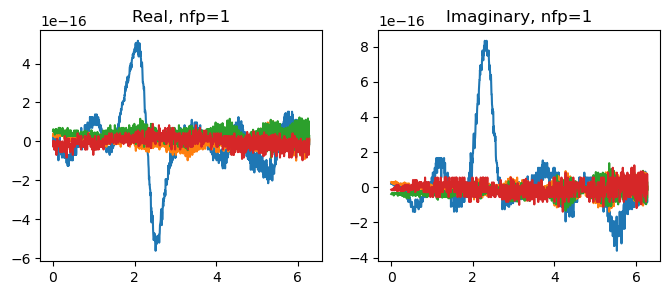

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             5.005e-17      
Worst:          inf             5.621e-16      
Std             nan             7.605e-17      
Total imaginary component
0.0

integral_mode is spline
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
Batch spline time(s): 0.020598173141479492
Difference


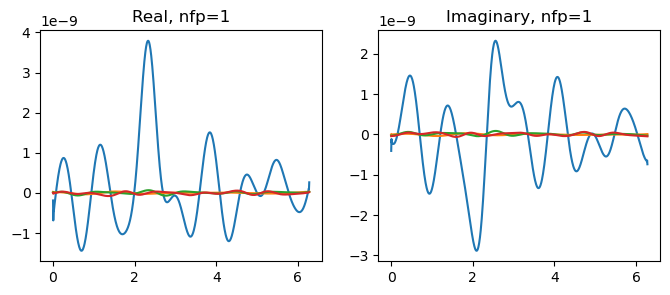

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.038e-10      
Worst:          inf             3.791e-09      
Std             nan             4.866e-10      
Total imaginary component
0.0

integral_mode is spline
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
This is  the naive implementation. Please implement periodic spline with scipy.interpolate.splrep
Batch double-spline time(s): 0.014597892761230469
Difference


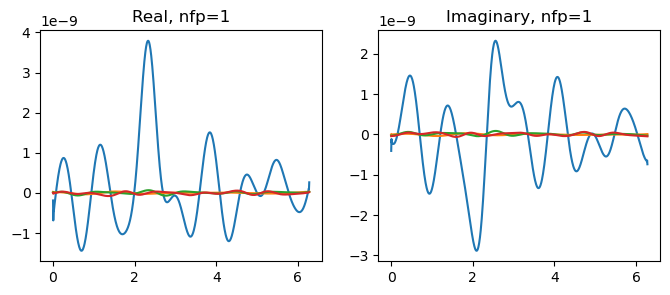

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             2.038e-10      
Worst:          inf             3.791e-09      
Std             nan             4.866e-10      
Total imaginary component
0.0

Modes: ['asymptotic', 'fft', 'fft', 'fft']
solve_integration_factor: not all components use the same integral_mode. Solving each component individially
integral_mode is fft
integral_mode is asymptotic
integral_mode is fft
integral_mode is fft
individual time(s): 0.03760504722595215
Difference


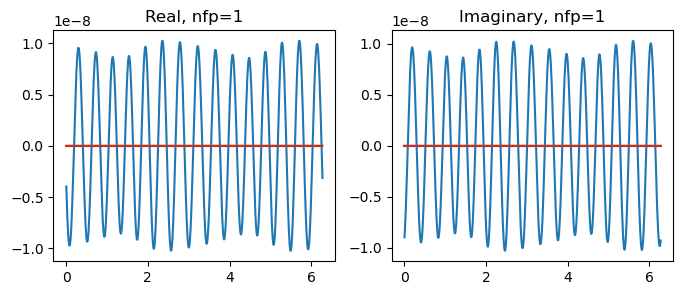

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             1.511e-09      
Worst:          inf             1.025e-08      
Std             nan             3.003e-09      
Total imaginary component
0.0



In [8]:
print('Testing general integrating factor')
# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
a = 100*np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS,integral_mode='asymptotic')
print("Batch asymptotic time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp,1),test1)

# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
a = 1*np.array([5*np.e**(2j*points),
              np.e**(1j*points), 
              np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS,integral_mode='fft', fft_max_freq=50)
print("Batch fft time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp,1),test1)

# By trying different amplitudes above, the theeshold of 
# instability seems to be 17.
start_time = time.time()
RHS = a*test1.content+b*dphi_test1.content
guess_batch_asymp = solve_integration_factor(a,b,RHS,integral_mode='spline')
print("Batch spline time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_asymp,1),test1)

start_time = time.time()
RHS = a*test1.content+b*dphi_test1.content
guess_batch_int = solve_integration_factor(a,b,RHS,integral_mode='spline')
print("Batch double-spline time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_batch_int,1),test1)

start_time = time.time()
a = np.array([50*np.e**(2j*points),
              np.e**(1j*points), 
              20*np.e**(3j*points), 
              np.e**(4j*points)], dtype = np.complex128)+0.5
b = 1
RHS = a*test1.content+b*dphi_test1.content
guess_ind = solve_integration_factor(a,b,RHS, fft_max_freq=50)
print("individual time(s):",(time.time() - start_time))
compare_chiphifunc(ChiPhiFunc(guess_ind,1),test1)



Testing solve_dphi_iota_dchi
Simpson mode
integral_mode is simpson
Difference


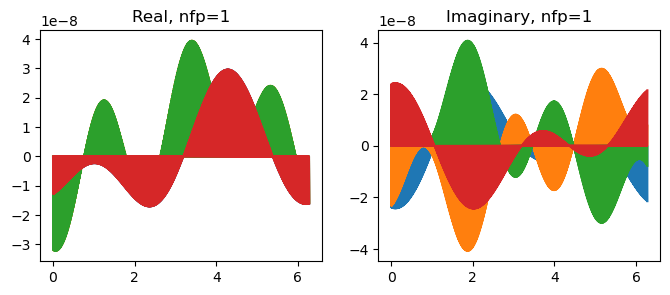

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            inf             7.199e-09      
Worst:          inf             3.942e-08      
Std             nan             9.818e-09      
Total imaginary component
0.0



In [11]:
print('Testing solve_dphi_iota_dchi')

print('Simpson mode')
test1_guess = solve_dphi_iota_dchi(iota, (dphi_test1+iota*dchi_test1).content, integral_mode = 'simpson')
compare_chiphifunc(ChiPhiFunc(test1_guess,1),test1)

# Testing $(A+B\partial_\chi)y=b$ linear system solver (Works!)

In [15]:
# Generating coefficients
nfp = 5
coef_A = rand_ChiPhiFunc(2,nfp)
coef_B = rand_ChiPhiFunc(2,nfp)
coef_C = rand_ChiPhiFunc(3,nfp)

## Odd with center as free component

Difference


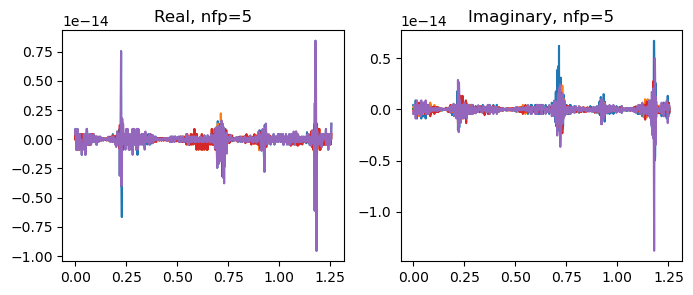

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            8.788e-04       1.952e-16      
Worst:          2.314e+00       9.548e-15      
Std             4.026e-02       4.837e-16      
Total imaginary component
0.0



In [17]:
test_Y = rand_ChiPhiFunc(5, nfp)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

O_matrices, O_einv, vector_free_coef, Y_nfp = \
    ChiPhiFunc.get_O_O_einv_from_A_B(coef_A, coef_B, 2, 4)

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[0].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content, nfp), test_Y)

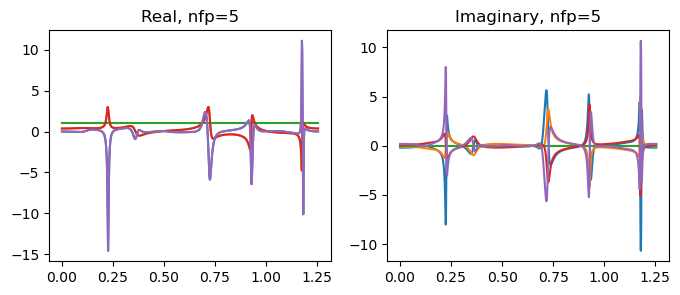

In [19]:
ChiPhiFunc(vector_free_coef, nfp).display_content()

## Even with $m=+1$ as free component

Difference


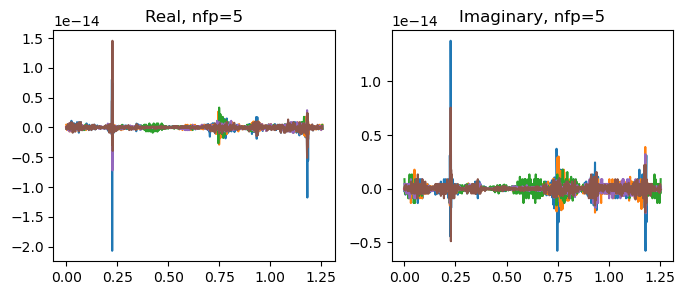

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            1.505e-15       1.801e-16      
Worst:          9.155e-13       2.071e-14      
Std             2.006e-14       4.999e-16      
Total imaginary component
0.0



In [22]:
test_Y = rand_ChiPhiFunc(6, nfp)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

O_matrices, O_einv, vector_free_coef, Y_nfp = \
    ChiPhiFunc.get_O_O_einv_from_A_B(coef_A, coef_B, 3, 5)

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[1].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content, Y_nfp), test_Y)

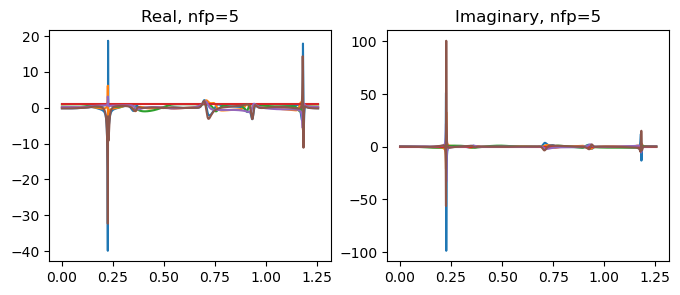

In [23]:
ChiPhiFunc(vector_free_coef, Y_nfp).display_content(fourier_mode=False)

In [46]:
test_Y = rand_ChiPhiFunc(6)
RHS = coef_A*test_Y+coef_B*test_Y.dchi()

i_1p = 3
i_1n = 2

O_matrices, O_einv, vector_free_coef = \
    ChiPhiFunc.get_O_O_einv_from_A_B(coef_A, coef_B, i_1p, 5)


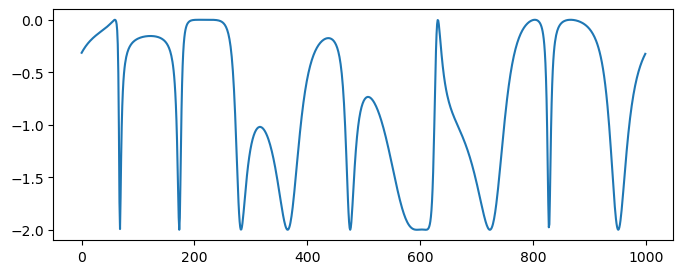

In [47]:
plt.plot(vector_free_coef[i_1n]-1)


In [48]:

vec_free = (np.einsum('ik,ik->k',O_einv[i_1n],RHS.content) + (test_Y[1]+test_Y[-1]).content[0])/(vector_free_coef[i_1n]-1)



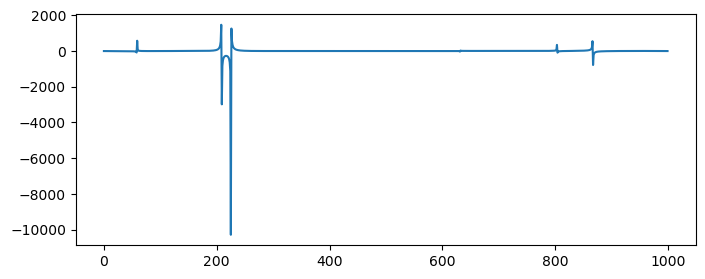

In [49]:
plt.plot(vec_free)

In [ ]:

guess_Y_content = (np.einsum('ijk,jk->ik',O_einv,RHS.content) + test_Y[1].content[0] * vector_free_coef)
compare_chiphifunc(ChiPhiFunc(guess_Y_content), test_Y)